<h2 style="color: green;">AlexNet</h2>

### *data 전처리*

- 이미지 크기 256x256으로 고정
이미지를 동일한 크기(256x256)으로 고정시켜줬습니다. 나중에 FC layer의 입력 크기가 고정되어있어야 하기 때문입니다. 만약 입력 이미지의 크기가 다르다면 FC layer에 입력되는 feature 개수가 모두 다르게 됩니다. resize 방법은 이미지의 넓이와 높이 중 더 짧은 쪽을 256으로 고정시키고 중앙 부분을 256x256 크기로 crop해주었습니다.

- 각 이미지의 pixel에 trainig set의 평균을 빼기
각 이미지의 pixel에 traing set의 평균을 빼서 normalize 해주었습니다.

### *병렬 구조*

기본구조는 LeNet-5와 크게 다르지 않다. 2개의 GPU로 병렬연산을 수행하기 위해서 병렬적인 구조 로 설계되었다는 점이 가장 큰 변화이다.

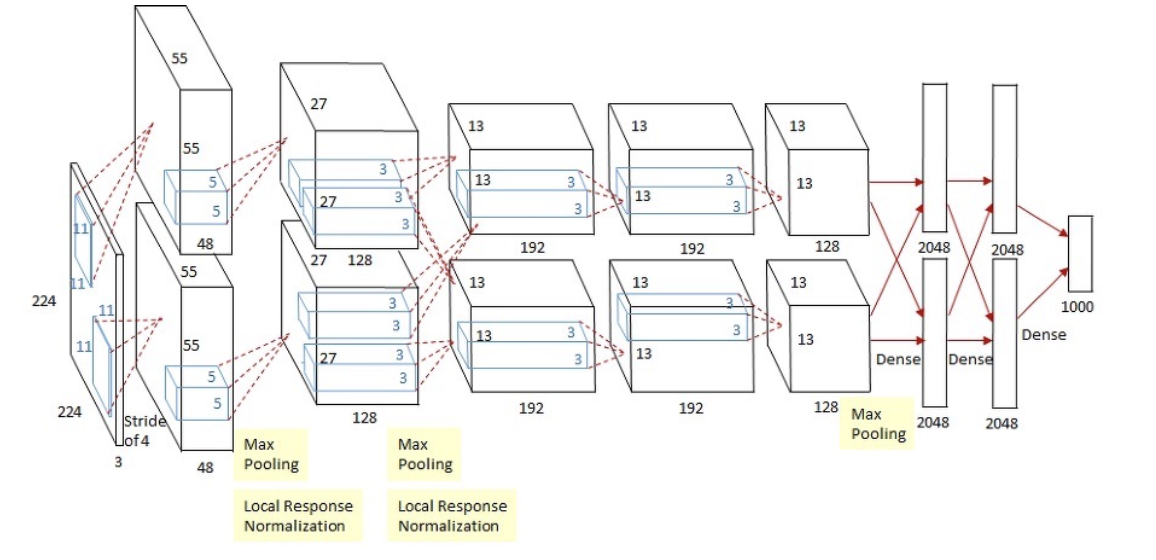

AlexNet은 8개의 레이어로 구성되어 있다. 5개의 컨볼루션 레이어와 3개의 full-connected 레이어로 구성되어 있다. 두번째, 네번째, 다섯번째 컨볼루션 레이어들은 전 단계의 같은 채널의 특성맵들과 만 연결되어 있는 반면, **세번째 컨볼루션 레이어는 전 단계의 두 채널의 특성맵들과 모두 연결되어 있다는 것을 집고 넘어가자.**

### *ReLU Nonlinearity*

활성화 함수로 ReLU 를 적용했습니다.
논문에서는 saturating nonlinearity(tanh, sigmoid)보다 non-saturatung nonlinearity(ReLU)의 학습 속도가 몇배는 빠르다고 나와있습니다.

### *Training on Multiple GPUs*

network를 2개의 GPU로 나누어서 학습시켰습니다. 이를 GPU parallelization이라고 합니다.


여기서 추가적인 기법이 있는데, 데이터를 두 개의 GPU로 나누어 학습시키다가 하나의 layer에서만 GPU를 통 합시키는 것입니다. 논문에서는 3번째 Conv layer에서만 GPU를 통합시킨다고 말합니다. 이를 통해 계산량의 허용가능한 부분까지 통신량을 정확하게 조정할 수 있다고 나와있습니다.

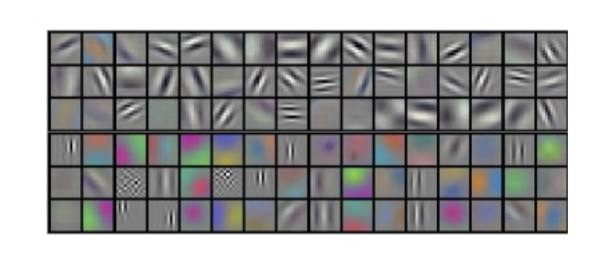

그림은 GPU 1, GPU 2 각각에서 학습된 kernel map 입니다. GPU 1에서는 색상과 관련 없는 정보를 학습하고 GPU 2는 색상과 관련된 정보를 학습 하는 것을 확인할 수 있습니다.

### *Local Response Normalization(LRN)*

LRN은 generalizaion을 목적으로 합니다. sigmoid나 tanh 함수는 입력 date의 속성이 서로 편차가 심하면 saturating되는 현상이 심해져 vanishing gradient를 유발할 수 있게 됩니다. 반면에 ReLU는 non-saturating nonlinearity 함수이기 때문에 saturating을 예방하기 위한 입력 normalizaion이 필요로 하지 않는 성질을 갖고 있 습니다.

ReLU는 양수값을 받으면 그 값을 그대로 neuron에 전달하기 때문에 너무 큰 값이 전달되어 주변의 낮은 값이 neuron에 전달되는 것을 막을 수 있습니다. 이것을 예방하기 위한 normalization이 LRN 입니다.

### *Overlapping Pooling*

overlapping 풀링과 non-overlapping 풀링을 비교한 그림은 아래와 같다. 편의를 위해 최대 풀링인 경우로 설명했다.

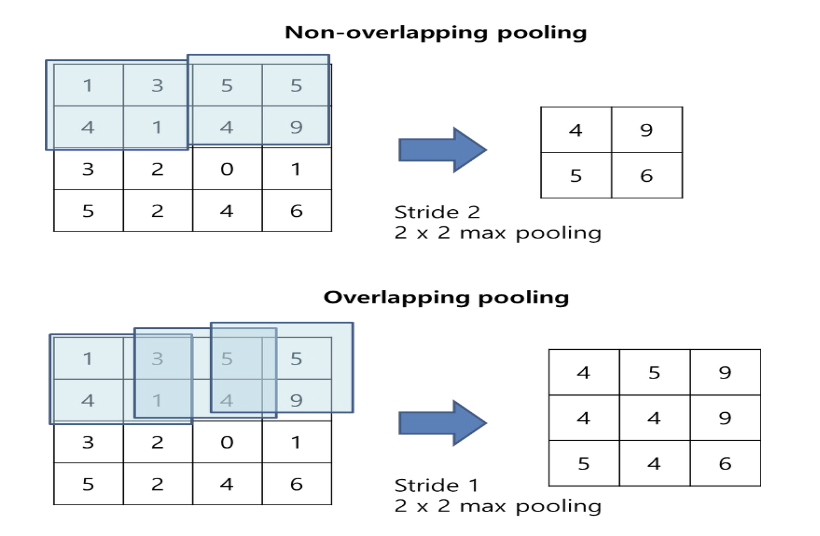

overlapping 풀링을 하면 풀링 커널이 중첩되면서 지나가는 반면, non-overlapping 풀링을 하면 중첩없이 진행된다. overlapping 풀링이 top-1, top-5 에러율을 줄이는데 좀 더 효과가 있다고 한다.

<h2 style="color: green;">AlexNet 과적합 방지 방법</h2>

AlexNet에는 6천만개의 파라미터가 존재하는데 이런 방대한 파라미터들을 학습하면서 과적합을 피하기는 쉽지않다. 그래서 2가지 방법을 사용하여 과적합을 방지한다.

### *Data Augmentation*

Data Augmentation은 현재 갖고 있는 데이터를 좀 더 다양하게 만들어 CNN 모델을 학습시키기 위해 만들어진 개 념입니다. 이러한 기법은 적은 노력으로 다양한 데이터를 형성하게하여 overfitting을 피하게 만들어 줍니다. 또한 data augmentation의 연산량은 매우 적고 CPU에서 이루어지기 때문에 계산적으로 부담이 없다고 말합니다.

**Generating image translation and horizontal reflections**

256x256 이미지에서 224x224 크기로 crop을 합니다. crop 위치는 중앙, 좌측 상단, 좌측 하단, 우측 상단, 우측 하 단 이렇게 5개의 위치에서 crop을 합니다. crop으로 생성된 5개의 이미지를 horizontal reflection을 합니다. 따라서 하나의 이미지에서 10개의 이미지가 생성됩니다.

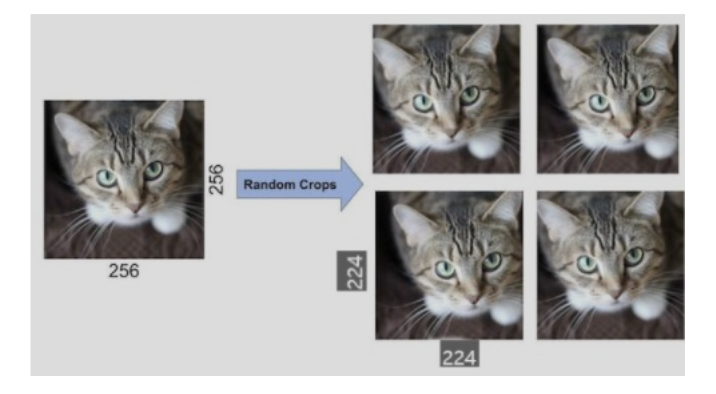

**Altering the intensirties of the RGB channels in training images**

ImageNet의 training set에 RGB pixel 값에 대한 PCA를 적용했습니다. PCA를 수행하여 RGB 각 생상에 대한 eigenvalue를 찾습니다. eigenvalue와 평균 0, 분산 0.1인 가우시안 분포에서 추출한 랜덤 변수를 곱해서 RGB 값에 더해줍니다.

### *Dropout*

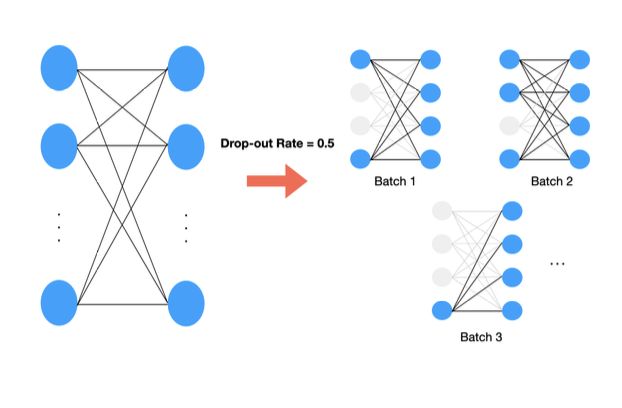

서로 다른 모델의 예측을 결합하는 앙상블 기법은 test error를 감소시 키기 효과적인 방법입니다. 하지만 AlexNet은 학습시키는데에 몇일이 걸려 이것을 적용하기가 힘들었다고 합니다. 따라서 모델 결합의 효과적인 버전인 dropout을 적용시켰다고 합니다.

매 입력마다 dropout을 적용시키면 가중치 는 공유되지만 신경망은 서로 다른 구조를 띄게 됩니다. neuron은 특정 다른 neuron의 존재에 의존하지 않기 때문에 이 기법은 복잡한 neuron 의 co-adaptation를 감소시킨다고 말합니다. 그러므로 서로 다른 neuron 의 임의의 부분 집합끼리 결합에 유용한 robust 특징을 배울 수 있다고 말합니다.

<h2 style="color: green;">AlexNet 구조</h2>

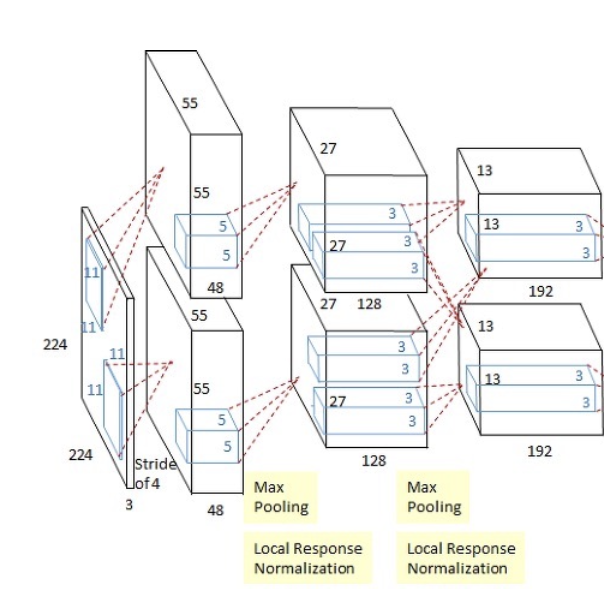

### *Convolution layer_1*
컨볼루션 보폭(stride)를 4로 설정했고, zero-padding은 사용하지 않았다. zero-padding은 컨볼루션으로 인해 특성맵의 사이즈가 축소되는 것을 방지하기 위해, 또는 축소되는 정도 를 줄이기 위해 영상의 가장자리 부분에 0을 추가하는 것이다.

결과적으로 55 x 55 x 96 특성맵(96장의 55 x 55 사이즈 특성맵들)이 산출된다. 그 다음에 ReLU 함수로 활성화해준다. 이어서 3 x 3 overlapping max pooling이 stride 2로 시행된다. 그 결과 27 x 27 x 96 특성맵을 갖게 된다. 그 다음에는 수렴 속도를 높이기 위해 local response normalization이 시행된다. local response normalization은 특성맵의 차원을 변 화시키지 않으므로, 특성맵의 크기는 27 x 27 x 96으로 유지된다.

### *Convolution layer_2*
256개의 5 x 5 x 48 커널을 사용하여 전 단계의 특성맵을 컨볼루션해준다. stride는 1로, zero-padding은 2로 설정했다.

따라서 27 x 27 x 256 특성맵(256장의 27 x 27 사이즈 특성맵들)을 얻게 된다. 역시 ReLU 함수로 활성화한다. 그 다음에 3 x 3 overlapping max pooling을 stride 2로 시행한다.

그 결과 13 x 13 x 256 특성맵을 얻게 된다. 그 후 local response normalization이 시행되고, 특성맵의 크기는 13 x 13 x 256으로 그대로 유지된다.

### *Convolution layer_3*
384개의 3 x 3 x 256 커널을 사용하여 전 단계의 특성맵을 컨볼루션해준다. stride와 zero-padding 모두 1로 설정한다.

따라서 13 x 13 x 384 특성맵(384장의 13 x 13 사이즈 특성맵들)을 얻게 된다. 역시 ReLU함수로 활성화한다.

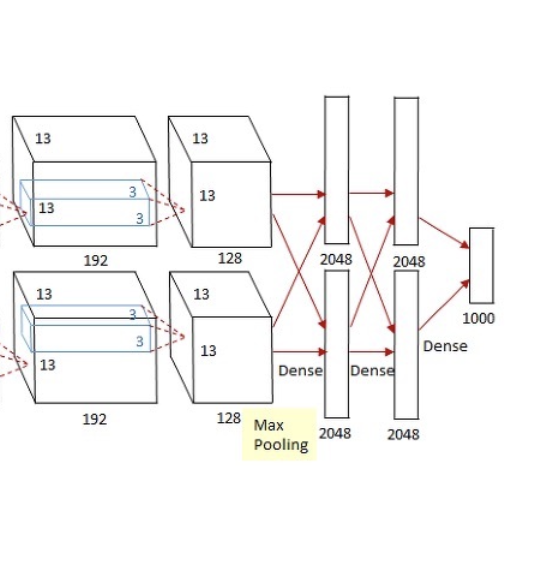

### *Convolution layer_4*
384개의 3 x 3 x 192 커널을 사 용해서 전 단계의 특성맵을 컨볼루션해준다. stride와 zero-padding 모두 1로 설정한다.

따라서 13 x 13 x 384 특성맵(384장의 13 x 13 사이즈 특성맵들)을 얻게 된다. 역시 ReLU 함수로 활성화한다.

### *Convolution layer_5*
256개의 3 x 3 x 192 커널을 사용 해서 전 단계의 특성맵을 컨볼루션해준다. stride와 zero-padding 모두 1 로 설정한다.

따라서 13 x 13 x 256 특성맵(256장의 13 x 13 사이즈 특성맵들)을 얻게 된다. 역시 ReLU 함수로 활성화한다. 그 다음에 3 x 3 overlapping max pooling을 stride 2로 시행한다. 그 결과 6 x 6 x 256 특성맵을 얻게 된다.

### *Fully connected layer_1*
6 x 6 x 256 특성맵을 flatten해줘서 6 x 6 x 256 = 9216차원의 벡터로 만들어준다. 그것을 여섯번째 레이어의 4096개의 뉴런과 fully connected 해준다. 그 결과를 ReLU 함수로 활성화한다.

### *Fully connected layer_2*
4096개의 뉴런으로 구성되어 있다. 전 단계의 4096개 뉴런과 fully connected되어 있다. 출력 값은 ReLU 함수로 활성화 된다.

### *Fully connected layer_3*
1000개의 뉴런으로 구성되어 있다. 전 단계의 4096개 뉴런과 fully connected되어 있다. 1000개 뉴런의 출력값에 Softmax적용해 1000개 클래스 각각에 속할 확률을 나타낸다.

<h2 style="color: green;">AlexNet의 한계</h2>

+ **모델 크기와 복잡성**: AlexNet은 상대적으로 크고 복잡한 모델입니다. 총 60백만 개의 파라미터로 구성되어 있으며, 이는 작은 규모의 데이터셋에서는 과적합의 위험성을 증가시킬 수 있습니다.
<br></br>
+ **메모리 요구 사항**: AlexNet은 입력 이미지의 크기가 크고 복잡한 계산을 수행하므로, GPU의 메모리 요구사항이 매우 높습니다. 따라서 메모리 용량이 작은 GPU에서는 학습과 추론에 어려움을 겪을 수 있습니다. 학습 시간: AlexNet은 큰 모델이므로 학습에 상당한 시간이 소요될 수 있습니다. 더 많은 계층과 파라미터를 가진 최신 CNN 아키텍처와 비교할 때 상대적으로 느릴 수 있습니다.
<br></br>
+ **규제 부족**: AlexNet은 드롭아웃(dropout)과 같은 규제(regularization) 기법을 사용하지 않습니다. 이는 모델이 훈련 데이터에 과적합되기 쉬울 수 있음을 의미합니다.
<br></br>
+ **활성화 함수**: AlexNet은 ReLU(Rectified Linear Unit) 활성화 함수를 사용합니다. 이 함수는 음수 입력에 대 해 0을 출력하는 특징을 가지는데, 이는 일부 정보 손실을 초래할 수 있습니다.